# Neural Machine Translation with Attention

Advanced Learning Fall 2025


For SUBMISSION:   

Please upload the complete and executed `ipynb` to your git repository. Verify that all of your output can be viewed directly from github, and provide a link to that git file below.

~~~
STUDENT ID: 208230607
~~~

~~~
STUDENT GIT LINK: https://github.com/itay-matityahu/comp_learning_2026
~~~
In Addition, don't forget to add your ID to the files, and upload to moodle the html version:    
  
`PS3_Attention_2025_ID_[000000000].html`   




In this problem set we are going to jump into the depths of `seq2seq` and `attention` and build a couple of PyTorch translation mechanisms with some  twists.     


*   Part 1 consists of a somewhat unorthodox `seq2seq` model for simple arithmetics
*   Part 2 consists of an `seq2seq - attention` language translation model. We will use it for Hebrew and English.  


---

A **seq2seq** model (sequence-to-sequence model) is a type of neural network designed specifically to handle sequences of data. The model converts input sequences into other sequences of data. This makes them particularly useful for tasks involving language, where the input and output are naturally sequences of words.

Here's a breakdown of how `seq2seq` models work:

* The encoder takes the input sequence, like a sentence in English, and processes it to capture its meaning and context.

* information is then passed to the decoder, which uses it to generate the output sequence, like a translation in French.

* Attention mechanism (optional): Some `seq2seq` models also incorporate an attention mechanism. This allows the decoder to focus on specific parts of the input sequence that are most relevant to generating the next element in the output sequence.

`seq2seq` models are used in many natural language processing (NLP) tasks.



imports: (feel free to add)

In [1]:
# from __future__ import unicode_literals, print_function, division
# from io import open
# import unicodedata
import re
import random
import unicodedata

import time
import math

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Part 1: Seq2Seq Arithmetic model

**Using RNN `seq2seq` model to "learn" simple arithmetics!**

> Given the string "54-7", the model should return a prediction: "47".  
> Given the string "10+20", the model should return a prediction: "30".


- Watch Lukas Biewald's short [video](https://youtu.be/MqugtGD605k?si=rAH34ZTJyYDj-XJ1) explaining `seq2seq` models and his toy application (somewhat outdated).
- You can find the code for his example [here](https://github.com/lukas/ml-class/blob/master/videos/seq2seq/train.py).    



1.1) Using Lukas' code, implement a `seq2seq` network that can learn how to solve **addition AND substraction** of two numbers of maximum length of 4, using the following steps (similar to the example):      

* Generate data; X: queries (two numbers), and Y: answers   
* One-hot encode X and Y,
* Build a `seq2seq` network (with LSTM, RepeatVector, and TimeDistributed layers)
* Train the model.
* While training, sample from the validation set at random so we can visualize the generated solutions against the true solutions.    

Notes:  
* The code in the example is quite old and based on Keras. You might have to adapt some of the code to overcome methods/code that is not supported anymore. Hint: for the evaluation part, review the type and format of the "correct" output - this will help you fix the unsupported "model.predict_classes".
* Please use the parameters in the code cell below to train the model.     
* Instead of using a `wandb.config` object, please use a simple dictionary instead.   
* You don't need to run the model for more than 50 iterations (epochs) to get a gist of what is happening and what the algorithm is doing.
* Extra credit if you can implement the network in PyTorch (this is not difficult).    
* Extra credit if you are able to significantly improve the model.

In [2]:
config = {}
config["training_size"] = 40000
config["digits"] = 4
config["hidden_size"] = 128
config["batch_size"] = 128
config["iterations"] = 50
chars = '0123456789-+ '

### 1.1

In [4]:

class CharacterTable(object):
    """Given a set of characters:
    + Encode them to a one hot integer representation
    + Decode the one hot integer representation to their character output
    + Decode a vector of probabilities to their character output
    """
    def __init__(self, chars):
        """Initialize character table.
        # Arguments
            chars: Characters that can appear in the input.
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        """One hot encode given string C.
        # Arguments
            num_rows: Number of rows in the returned one hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)

class Seq2SeqArithmetic(nn.Module):
    def __init__(self, input_vocab_size, hidden_size, output_vocab_size, output_len):
        super(Seq2SeqArithmetic, self).__init__()
        self.hidden_size = hidden_size
        self.output_len = output_len

        # --- Encoder ---
        # input_vocab_size is len(chars)
        self.encoder_lstm = nn.LSTM(input_size=input_vocab_size,
                                    hidden_size=hidden_size,
                                    batch_first=True)

        # --- Decoder ---
        # The decoder LSTM takes the "Context Vector" as input at every step
        self.decoder_lstm = nn.LSTM(input_size=hidden_size,
                                    hidden_size=hidden_size,
                                    batch_first=True)

        # TimeDistributed Dense (Linear layer in PyTorch)
        self.fc = nn.Linear(hidden_size, output_vocab_size)

    def forward(self, x):
        # 1. Encoder: process the whole input sequence
        # We only care about the final hidden state (the context vector)
        _, (h_n, c_n) = self.encoder_lstm(x)

        # 2. "RepeatVector": Repeat h_n to match output_len
        # h_n shape: (1, batch, hidden) -> permute to (batch, 1, hidden)
        context_vector = h_n.permute(1, 0, 2)
        # Repeat it for the length of the answer (digits + 1)
        decoder_input = context_vector.repeat(1, self.output_len, 1)

        # 3. Decoder: unpack the context vector into a sequence
        # We use the final encoder states (h_n, c_n) to initialize the decoder
        decoder_output, _ = self.decoder_lstm(decoder_input, (h_n, c_n))

        # 4. "TimeDistributed": apply Linear layer to every time step
        prediction = self.fc(decoder_output)

        return prediction


In [14]:


maxlen = config['digits'] + 1 + config['digits']
ctable = CharacterTable(chars)

questions = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < config["training_size"]:
    f = lambda: int(''.join(np.random.choice(list('0123456789'))
                    for i in range(np.random.randint(1, config['digits'] + 1))))
    a, b = f(), f()
    # Skip any addition questions we've already seen
    # Also skip any such that x+Y == Y+x (hence the sorting).
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    # Pad the data with spaces such that it is always MAXLEN.
    q = '{}-{}'.format(a, b)
    query = q + ' ' * (maxlen - len(q))
    ans = str(a - b)
    # Answers can be of maximum size DIGITS + 1.
    ans += ' ' * (config['digits'] + 1 - len(ans))

    questions.append(query)
    expected.append(ans)

print('Total addition questions:', len(questions))


x = np.zeros((len(questions), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(questions), config['digits'] + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
  x[i] = ctable.encode(sentence, maxlen)
for i, sentence in enumerate(expected):
  y[i] = ctable.encode(sentence, config['digits'] + 1)

indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=42)

x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

x_val_tensor = torch.from_numpy(x_val).float()
y_val_tensor = torch.from_numpy(y_val).float()

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)

Generating data...
Total addition questions: 40000


In [ ]:
model = Seq2SeqArithmetic(
    input_vocab_size=len(chars),
    hidden_size=config["hidden_size"],
    output_vocab_size=len(chars),
    output_len=config["digits"] + 1
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(config["iterations"]):
  model.train()
  total_loss = 0

  for i, (x_batch, y_batch) in enumerate(train_loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    pred = model(x_batch)

    flat_pred = pred.view(-1, len(chars))
    flat_real = torch.argmax(y_batch, dim=-1).view(-1)

    loss = criterion(flat_pred, flat_real)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  model.eval()
  char_acc = 0
  seq_acc = 0
  total_samples = 0

  with torch.no_grad():
    for x_val, y_val in val_loader:
      x_val, y_val = x_val.to(device), y_val.to(device)

      outputs = model(x_val)

      pred_indices = torch.argmax(outputs, dim=-1)
      target_indices = torch.argmax(y_val, dim=-1)
      correct_matrix = (pred_indices == target_indices)

      char_acc += correct_matrix.sum().item()
      seq_acc += (correct_matrix.all(dim=1)).sum().item()
      total_samples += x_val.size(0)
    total_chars = total_samples * (config["digits"] + 1)
  if (epoch+1) % 5 == 0:
    print(f"Epoch {epoch+1}/{config['iterations']}, Loss: {total_loss/len(train_loader):.4f}")
    print(f"Character Accuracy: {char_acc / total_chars:.4f}")
    print(f"Full Equation Accuracy: {seq_acc / total_samples:.4f}")

for i in range(5):
    idx = random.randint(0, x_val.size(0) - 1)
    q = ctable.decode(x_val[idx].cpu().numpy())
    expected = ctable.decode(y_val[idx].cpu().numpy())
    predicted = ctable.decode(pred_indices[idx].cpu().numpy(), calc_argmax=False)
    print(f"Q: {q} | Expected: {expected} | Predicted: {predicted}")


Epoch 5/50, Loss: 1.5110
Character Accuracy: 0.4294
Full Equation Accuracy: 0.0025
Epoch 10/50, Loss: 1.2587
Character Accuracy: 0.5118
Full Equation Accuracy: 0.0088
Epoch 15/50, Loss: 1.0782
Character Accuracy: 0.5857
Full Equation Accuracy: 0.0217
Epoch 20/50, Loss: 0.9619
Character Accuracy: 0.6371
Full Equation Accuracy: 0.0423
Epoch 25/50, Loss: 0.8663
Character Accuracy: 0.6645
Full Equation Accuracy: 0.0650
Epoch 30/50, Loss: 0.7850
Character Accuracy: 0.6872
Full Equation Accuracy: 0.1027
Epoch 35/50, Loss: 0.7134
Character Accuracy: 0.7134
Full Equation Accuracy: 0.1400
Epoch 40/50, Loss: 0.6467
Character Accuracy: 0.7274
Full Equation Accuracy: 0.1840
Epoch 45/50, Loss: 0.5770
Character Accuracy: 0.7531
Full Equation Accuracy: 0.2340
Epoch 50/50, Loss: 0.5116
Character Accuracy: 0.7623
Full Equation Accuracy: 0.2722
Q: 44-8513   | Expected: -8469 | Predicted: -8478
Q: 8811-86   | Expected: 8725  | Predicted: 8742 
Q: 61-1419   | Expected: -1358 | Predicted: -1358
Q: 496-5   

---

### 1.2

1.2).

a) Do you think this model performs well?  Why or why not?     
b) What are its limitations?   
c) What would you do to improve it?    
d) Can you apply an attention mechanism to this model? Why or why not?   

a. The model got accuracy of 76% accuracy when examine character accuracy which is nice, but when looking on solution accuracy we can see that only 27% of the model answers are true and therefore the model has a lot to improve.
Anyway, it still has better performance than lukas model (69%).

b. As mentioned before, The model has nice accuracy when trying to predict one number, but for solving larger problems the probabily to success decreased significantly (0.76^n). It is the major limit of the model.

c. The model can be improved using more lstm layers / Bilstm / attention or any architecture that may improve the memory and context of the previous charactars. It also can be improved by teacher forcing.

d. Yes, attention can be added to this model and may be very helpfull when dealing with data like this since there is true connection between the characters, and attention can capture it.

### 1.3

1.3).  

Add attention to the model. Evaluate the performance against the `seq2seq` you trained above. Which one is performing better?

The model with the attention addition has very similar performance but a littelt bit lower that the first one in surprisingly way.

In [1]:
# 1. THE ATTENTION MECHANISM
# Calculates which part of the input sequence to focus on
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Linear(hidden_size, 1)

    def forward(self, hidden, encoder_outputs):
        # hidden: [1, batch, hidden_size] | encoder_outputs: [batch, seq_len, hidden_size]
        src_len = encoder_outputs.shape[1]

        # Repeat hidden state for every time-step in encoder_outputs
        hidden = hidden.transpose(0, 1).repeat(1, src_len, 1)

        # Calculate scores
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)

        return F.softmax(attention, dim=1)

# 2. THE ENCODER
# Processes the question and returns ALL hidden states
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_size):
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_size, batch_first=True)

    def forward(self, x):
        outputs, (hidden, cell) = self.lstm(x)
        return outputs, hidden, cell

# 3. THE DECODER
# Predicts one character at a time using attention
class DecoderWithAttention(nn.Module):
    def __init__(self, output_dim, hidden_size, attention):
        super(DecoderWithAttention, self).__init__()
        self.attention = attention
        self.lstm = nn.LSTM(hidden_size + output_dim, hidden_size, batch_first=True)
        self.fc_out = nn.Linear(hidden_size * 2, output_dim)

    def forward(self, input_char, hidden, cell, encoder_outputs):
        # Calculate attention weights and context vector
        a = self.attention(hidden, encoder_outputs).unsqueeze(1)
        weighted = torch.bmm(a, encoder_outputs) # [batch, 1, hidden]

        # Combine input and context for LSTM
        input_char = input_char.unsqueeze(1) # [batch, 1, vocab_size]
        rnn_input = torch.cat((input_char, weighted), dim=2)

        output, (hidden, cell) = self.lstm(rnn_input, (hidden, cell))

        # Final prediction by combining LSTM output and context
        prediction = self.fc_out(torch.cat((output, weighted), dim=2))
        return prediction, hidden, cell

# 4. THE MAIN SYSTEM
# Orchestrates the encoder and the decoder loop
class AttentionSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder, output_len):
        super(AttentionSeq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.output_len = output_len

    def forward(self, src):
        batch_size = src.shape[0]
        vocab_size = self.decoder.fc_out.out_features
        outputs = torch.zeros(batch_size, self.output_len, vocab_size).to(src.device)

        encoder_outputs, hidden, cell = self.encoder(src)

        # Initialize the first input as a zero vector (start of sequence)
        input_char = torch.zeros(batch_size, vocab_size).to(src.device)

        for t in range(self.output_len):
            prediction, hidden, cell = self.decoder(input_char, hidden, cell, encoder_outputs)
            outputs[:, t:t+1, :] = prediction

            # Use current prediction as the next input
            input_char = prediction.squeeze(1)

        return outputs


# Create the components
attn = Attention(config["hidden_size"])
enc = Encoder(len(chars), config["hidden_size"])
dec = DecoderWithAttention(len(chars), config["hidden_size"], attn)

# Initialize the main model
model = AttentionSeq2Seq(enc, dec, config["digits"] + 1).to(device)

# The rest of your code (Criterion, Optimizer) stays EXACTLY the same!
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:

for epoch in range(config["iterations"]):
  model.train()
  total_loss = 0

  for i, (x_batch, y_batch) in enumerate(train_loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    pred = model(x_batch)

    flat_pred = pred.view(-1, len(chars))
    flat_real = torch.argmax(y_batch, dim=-1).view(-1)

    loss = criterion(flat_pred, flat_real)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  model.eval()
  char_acc = 0
  seq_acc = 0
  total_samples = 0

  with torch.no_grad():
    for x_val, y_val in val_loader:
      x_val, y_val = x_val.to(device), y_val.to(device)

      outputs = model(x_val)

      pred_indices = torch.argmax(outputs, dim=-1)
      target_indices = torch.argmax(y_val, dim=-1)
      correct_matrix = (pred_indices == target_indices)

      char_acc += correct_matrix.sum().item()
      seq_acc += (correct_matrix.all(dim=1)).sum().item()
      total_samples += x_val.size(0)
    total_chars = total_samples * (config["digits"] + 1)
  if (epoch+1) % 5 == 0:
    print(f"Epoch {epoch+1}/{config['iterations']}, Loss: {total_loss/len(train_loader):.4f}")
    print(f"Character Accuracy: {char_acc / total_chars:.4f}")
    print(f"Full Equation Accuracy: {seq_acc / total_samples:.4f}")

for i in range(5):
    idx = random.randint(0, x_val.size(0) - 1)
    q = ctable.decode(x_val[idx].cpu().numpy())
    expected = ctable.decode(y_val[idx].cpu().numpy())
    predicted = ctable.decode(pred_indices[idx].cpu().numpy(), calc_argmax=False)
    print(f"Q: {q} | Expected: {expected} | Predicted: {predicted}")


Epoch 5/50, Loss: 1.4487
Character Accuracy: 0.4693
Full Equation Accuracy: 0.0060
Epoch 10/50, Loss: 1.1863
Character Accuracy: 0.5622
Full Equation Accuracy: 0.0125
Epoch 15/50, Loss: 1.0250
Character Accuracy: 0.6107
Full Equation Accuracy: 0.0283
Epoch 20/50, Loss: 0.9085
Character Accuracy: 0.6453
Full Equation Accuracy: 0.0590
Epoch 25/50, Loss: 0.8297
Character Accuracy: 0.6673
Full Equation Accuracy: 0.0835
Epoch 30/50, Loss: 0.7623
Character Accuracy: 0.6924
Full Equation Accuracy: 0.1115
Epoch 35/50, Loss: 0.7019
Character Accuracy: 0.7103
Full Equation Accuracy: 0.1405
Epoch 40/50, Loss: 0.6490
Character Accuracy: 0.7232
Full Equation Accuracy: 0.1688
Epoch 45/50, Loss: 0.6056
Character Accuracy: 0.7237
Full Equation Accuracy: 0.1730
Epoch 50/50, Loss: 0.5508
Character Accuracy: 0.7490
Full Equation Accuracy: 0.2380
Q: 6-3729    | Expected: -3723 | Predicted: -3723
Q: 4646-3    | Expected: 4643  | Predicted: 4652 
Q: 5527-3122 | Expected: 2405  | Predicted: 2518 
Q: 231-643 

### 1.4

1.4)

Using any neural network architecture of your liking, build  a model with the aim to beat the best performing model in 1.1 or 1.3. Compare your results in a meaningful way, and add a short explanation to why you think/thought your suggested network is better.

I  used transformer to this mission and the results was much higher than I expected with full equation accuracy of 99% and 99% accuray for each character. It is indeed much higher than both of the models above. The transformers enable the model to learn deep connection between the characters, nuuch better than lstm and thats why I thugh it will have better results.

In [32]:
class CharacterTable(object):
    def __init__(self, chars):
        self.chars = sorted(list(set(chars)))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def decode(self, x, calc_argmax=False):
        if calc_argmax:
            # Only use argmax if the input is One-Hot
            x = x.argmax(axis=-1)

        # We use 'ind' instead of 'x' to avoid shadowing the input variable
        return ''.join(self.indices_char[ind] for ind in x)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=50):
        super(PositionalEncoding, self).__init__()

        # 1. Create a matrix of zeros [max_len, d_model]
        pe = torch.zeros(max_len, d_model)

        # 2. Create a vector representing positions [0, 1, 2, ..., max_len-1]
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # 3. Calculate the division term for the sine/cosine functions
        # This corresponds to the 10000^(2i/d_model) part
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # 4. Apply sine to even indices and cosine to odd indices
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # 5. Add a batch dimension and register as a buffer (stays with the model but not trained)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x is the embedding matrix [Batch, Seq_Len, d_model]
        # We add the positional encoding to the embedding
        x = x + self.pe[:, :x.size(1)]
        return x


class TransformerInput(nn.Module):
    def __init__(self, vocab_size, d_model):
        super(TransformerInput, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model)

    def forward(self, x):
        # x contains the indices of the characters (from CharacterTable)
        # 1. Selection from the table (Embedding)
        x = self.embedding(x) # Output: [Batch, Seq, d_model]

        # 2. Addition of position (PE)
        x = self.pos_encoding(x)
        return x


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % num_heads == 0

        self.d_k = d_model // num_heads # Dimension of each head

        # Defining 4 linear layers
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)

        # 1. Linear projections and split into heads
        # View as: [Batch, Seq, Heads, d_k] -> Transpose to: [Batch, Heads, Seq, d_k]
        q = self.w_q(q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        k = self.w_k(k).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        v = self.w_v(v).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # 2. Scaled Dot-Product Attention
        # scores = (Q * K^T) / sqrt(d_k)
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attn = torch.softmax(scores, dim=-1)

        # 3. Multiply by V and Concatenate
        # context = (Attn * V)
        context = torch.matmul(attn, v) # [Batch, Heads, Seq, d_k]
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)

        # 4. Final output projection (W_o)
        return self.w_o(context)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(FeedForward, self).__init__()
        # 1st layer expands the dimension
        self.w_1 = nn.Linear(d_model, d_ff)
        # 2nd layer brings it back to d_model
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Apply Linear -> ReLU -> Dropout -> Linear
        return self.w_2(self.dropout(torch.relu(self.w_1(x))))


class EncoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(EncoderBlock, self).__init__()
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)

        # Two normalization layers for the two "floors" of the block
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # --- Floor 1: Multi-Head Attention ---
        # 1. Calculate attention (Self-Attention)
        attn_output = self.attention(x, x, x, mask)

        # 2. Add & Norm (Residual Connection)
        x = self.norm1(x + self.dropout(attn_output))

        # --- Floor 2: Feed Forward ---
        # 3. Apply Feed Forward
        ff_output = self.feed_forward(x)

        # 4. Add & Norm (Residual Connection)
        x = self.norm2(x + self.dropout(ff_output))

        return x

class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        # Input layer from Step A (Embedding + Positional Encoding)
        self.input_layer = TransformerInput(vocab_size, d_model)

        # Creating a stack of encoder blocks
        self.layers = nn.ModuleList([
            EncoderBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        # 1. Convert indices to vectors with position
        x = self.input_layer(x)

        # 2. Pass through each encoder block in the stack
        for layer in self.layers:
            x = layer(x, mask)

        return self.norm(x)

def create_look_ahead_mask(size):
    mask = torch.tril(torch.ones(size, size)).type(torch.uint8)
    return mask.unsqueeze(0) # Add batch dimension

class DecoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(DecoderBlock, self).__init__()
        # 1. Self Attention (looking at the answer so far)
        self.self_attn = MultiHeadAttention(d_model, num_heads)

        # 2. Cross Attention (looking at the encoder's output)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)

        self.feed_forward = FeedForward(d_model, d_ff, dropout)

        # We need 3 normalization layers now
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask=None, tgt_mask=None):
        """
        x: target sequence (the answer being generated)
        enc_output: the memory/output from the encoder
        src_mask: mask for the encoder (padding)
        tgt_mask: mask for the decoder (look-ahead + padding)
        """

        # --- Floor 1: Masked Self-Attention ---
        # Query, Key, Value all come from x
        attn1 = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn1))

        # --- Floor 2: Cross-Attention (The Connection!) ---
        # Query comes from the current decoder state (x)
        # Key and Value come from the Encoder (enc_output)
        attn2 = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn2))

        # --- Floor 3: Feed Forward ---
        x = self.norm3(x + self.dropout(self.feed_forward(x)))

        return x

class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff, dropout=0.1):
        super(TransformerDecoder, self).__init__()
        self.input_layer = TransformerInput(vocab_size, d_model)
        self.layers = nn.ModuleList([
            DecoderBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, enc_output, src_mask=None, tgt_mask=None):
        x = self.input_layer(x)
        for layer in self.layers:
            x = layer(x, enc_output, src_mask, tgt_mask)
        return self.norm(x)

def make_masks(src, tgt, pad_idx):
    # 1. Source Mask: Tells the encoder to ignore padding in the question
    src_mask = (src != pad_idx).unsqueeze(1).unsqueeze(2)

    # 2. Target Mask: Combined Padding Mask + Look-ahead Mask
    tgt_pad_mask = (tgt != pad_idx).unsqueeze(1).unsqueeze(2)
    tgt_len = tgt.size(1)
    look_ahead_mask = torch.tril(torch.ones(tgt_len, tgt_len)).type(torch.uint8).to(src.device)

    tgt_mask = tgt_pad_mask & look_ahead_mask.bool()

    return src_mask, tgt_mask

class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_layers, num_heads, d_ff, dropout=0.1):
        super(Transformer, self).__init__()

        # The two main parts we already built
        self.encoder = TransformerEncoder(src_vocab_size, d_model, num_layers, num_heads, d_ff, dropout)
        self.decoder = TransformerDecoder(tgt_vocab_size, d_model, num_layers, num_heads, d_ff, dropout)

        # Final Linear layer to project back to vocabulary size
        self.generator = nn.Linear(d_model, tgt_vocab_size)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        # 1. Encode the source (question)
        enc_output = self.encoder(src, src_mask)

        # 2. Decode using encoder's memory
        dec_output = self.decoder(tgt, enc_output, src_mask, tgt_mask)

        # 3. Project to vocabulary probabilities
        return self.generator(dec_output)

In [11]:
char_table = CharacterTable(chars)
pad_idx = char_table.char_indices[' ']

# 1. Configuration - adjust based on your character set
# If your chars are "0123456789+ ", then vocab size is 12
src_vocab_size = len(char_table.chars)
tgt_vocab_size = len(char_table.chars)

# Hyperparameters
d_model = 128
num_layers = 4      # Number of Encoder and Decoder blocks
num_heads = 8       # d_model must be divisible by num_heads (128/8 = 16)
d_ff = 512          # Dimension of the Feed Forward layer (usually 4x d_model)
dropout = 0.1

# 2. Instantiate the model
model = Transformer(
    src_vocab_size,
    tgt_vocab_size,
    d_model,
    num_layers,
    num_heads,
    d_ff,
    dropout
)

# 3. Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [12]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# --- 1. Constants and Config (Exactly as requested) ---
config = {
    "training_size": 40000,
    "digits": 4,
    "hidden_size": 128,
    "batch_size": 128,
    "iterations": 50
}
chars = '0123456789-+ '
ctable = CharacterTable(chars)

# Question length: digits + operator + digits (e.g., 4+1+4 = 9)
maxlen_q = config['digits'] + 1 + config['digits']
# Answer length: digits + 1 (for sign) + 1 (for SOS space)
maxlen_a = config['digits'] + 2

questions = []
expected = []
seen = set()

# --- 2. Data Generation Loop ---
print('Generating data...')
while len(questions) < config["training_size"]:
    f = lambda: int(''.join(np.random.choice(list('0123456789'))
                    for i in range(np.random.randint(1, config['digits'] + 1))))
    a, b = f(), f()

    # Ensuring unique questions (sorting keys for commutativity check if needed)
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)

    # Pad the question with spaces
    q = '{}-{}'.format(a, b)
    query = q + ' ' * (maxlen_q - len(q))

    # Prepend a space as SOS (Start of Sentence) and pad the answer
    ans = ' ' + str(a - b)
    ans += ' ' * (maxlen_a - len(ans))

    questions.append(query)
    expected.append(ans)

print(f'Total questions generated: {len(questions)}')

# --- 3. Vectorization (Mapping to Indices, NOT One-Hot) ---
# Shape: [Total_Samples, Seq_Length]
x = np.zeros((len(questions), maxlen_q), dtype=np.int64)
y = np.zeros((len(expected), maxlen_a), dtype=np.int64)

for i, sentence in enumerate(questions):
    x[i] = [ctable.char_indices[char] for char in sentence]

for i, sentence in enumerate(expected):
    y[i] = [ctable.char_indices[char] for char in sentence]

# --- 4. Shuffle and Split ---
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=42)

# --- 5. PyTorch Tensors and DataLoaders ---
# We use LongTensor because Embedding layers expect integers
x_train_tensor = torch.LongTensor(x_train)
y_train_tensor = torch.LongTensor(y_train)

x_val_tensor = torch.LongTensor(x_val)
y_val_tensor = torch.LongTensor(y_val)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)

print(f'Training size: {len(x_train)}, Validation size: {len(x_val)}')

Generating data...
Total questions generated: 40000
Training size: 36000, Validation size: 4000


In [13]:
epochs = config['iterations']
model.to(device)

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        src, tgt = batch[0].to(device), batch[1].to(device)

        # Teacher Forcing: Prepare inputs and labels
        tgt_input = tgt[:, :-1]
        tgt_labels = tgt[:, 1:]

        src_mask, tgt_mask = make_masks(src, tgt_input, pad_idx)

        preds = model(src, tgt_input, src_mask, tgt_mask)

        loss = criterion(
            preds.view(-1, preds.size(-1)),
            tgt_labels.contiguous().view(-1)
        )

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()

    # --- Validation Phase ---
    if (epoch + 1) % 5 == 0:
        model.eval()
        char_acc, total_chars, seq_acc, total_samples = 0, 0, 0, 0

        with torch.no_grad():
            for batch in val_loader:
                src, tgt = batch[0].to(device), batch[1].to(device)
                tgt_input = tgt[:, :-1]
                tgt_labels = tgt[:, 1:]

                src_mask, tgt_mask = make_masks(src, tgt_input, pad_idx)
                preds = model(src, tgt_input, src_mask, tgt_mask)
                pred_indices = preds.argmax(dim=-1)

                # Metrics logic
                mask = (tgt_labels != pad_idx)
                correct_chars = (pred_indices == tgt_labels) & mask
                char_acc += correct_chars.sum().item()
                total_chars += mask.sum().item()

                seq_matches = (pred_indices == tgt_labels).all(dim=1)
                seq_acc += seq_matches.sum().item()
                total_samples += src.size(0)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")
        print(f"Character Accuracy: {char_acc / total_chars:.4f}")
        print(f"Full Equation Accuracy: {seq_acc / total_samples:.4f}")

# --- Display 5 Examples ---
print("-" * 30)
for i in range(5):
    idx = random.randint(0, src.size(0) - 1)

    q = ctable.decode(src[idx].cpu().numpy())
    expected = ctable.decode(tgt_labels[idx].cpu().numpy())
    predicted = ctable.decode(pred_indices[idx].cpu().numpy())

    print(f"Q: {q} | Expected: {expected} | Predicted: {predicted}")
    print("-" * 30 + "\n")

Epoch 5/50, Loss: 0.9437
Character Accuracy: 0.5644
Full Equation Accuracy: 0.0808
Epoch 10/50, Loss: 0.7723
Character Accuracy: 0.6372
Full Equation Accuracy: 0.2052
Epoch 15/50, Loss: 0.6770
Character Accuracy: 0.6964
Full Equation Accuracy: 0.3033
Epoch 20/50, Loss: 0.5835
Character Accuracy: 0.7427
Full Equation Accuracy: 0.3815
Epoch 25/50, Loss: 0.4403
Character Accuracy: 0.8157
Full Equation Accuracy: 0.5450
Epoch 30/50, Loss: 0.2631
Character Accuracy: 0.9186
Full Equation Accuracy: 0.7688
Epoch 35/50, Loss: 0.1196
Character Accuracy: 0.9705
Full Equation Accuracy: 0.8995
Epoch 40/50, Loss: 0.0533
Character Accuracy: 0.9914
Full Equation Accuracy: 0.9683
Epoch 45/50, Loss: 0.0274
Character Accuracy: 0.9975
Full Equation Accuracy: 0.9878
Epoch 50/50, Loss: 0.0161
Character Accuracy: 0.9988
Full Equation Accuracy: 0.9955
------------------------------
Q: 0-60      | Expected: -60   | Predicted: -60  
------------------------------

Q: 663-4     | Expected: 659   | Predicted: 659 

## Part 2: A language translation model with attention

In this part of the problem set we are going to implement a translation with a Sequence to Sequence Network and Attention model.

### 0.

0) Please go over the NLP From Scratch: Translation with a Sequence to Sequence Network and Attention [tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html). This attention model is very similar to what was learned in class (Luong), but a bit different. What are the main differences between  Badahnau and Luong attention mechanisms?    

0. Bahdanau attention calculates the scores using the previous decoder state before generating the current word, whereas Luong attention uses the current decoder state. Mathematically, Bahdanau uses an additive function (a small neural network) to find the weights, while Luong typically uses a faster multiplicative (dot-product) approach.


### 1.a

1.a) Using `!wget`, `!unzip` , download and extract the [hebrew-english](https://www.manythings.org/anki/) sentence pairs text file to the Colab `content/`  folder (or local folder if not using Colab).
1.b) The `heb.txt` must be parsed and cleaned (see tutorial for requirements or change the code as you see fit).   


In [12]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

!wget -q https://www.manythings.org/anki/heb-eng.zip
!unzip -o heb-eng.zip

Archive:  heb-eng.zip
  inflating: _about.txt              
  inflating: heb.txt                 


In [11]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = s.lower().strip()
    # Separate punctuation
    s = re.sub(r"([.!?])", r" \1", s)
    # Keep English letters, Hebrew letters, and basic punctuation
    s = re.sub(r"[^a-zA-Z\u0590-\u05FF.!?]+", r" ", s)
    return s.strip()


def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")
    lines = open('heb.txt', encoding='utf-8').read().strip().split('\n')

    # FIX: Slice [0:2] to only get English and Hebrew, ignoring attribution
    pairs = [[normalizeString(s) for s in l.split('\t')[:2]] for l in lines]

    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'heb', True)
print(random.choice(pairs))

Reading lines...
Read 136845 sentence pairs
Trimmed to 9221 sentence pairs
Counting words...
Counted words:
heb 6101
eng 3050
['היא מקשיבה לו .', 'she is listening to him .']


### 2

2.a) Use the tutorial example to build  and train a Hebrew to English translation model with attention (using the parameters in the code cell below). Apply the same `eng_prefixes` filter to limit the train/test data.   
2.b) Evaluate your trained model randomly on 20 sentences.  
2.c) Show the attention plot for 5 random sentences.  


In [19]:
# use the following parameters:
MAX_LENGTH = 10
hidden_size = 128
epochs = 50

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden


class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights


def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'heb', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader


def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn


def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [20]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, epochs, print_every=5, plot_every=5)

Reading lines...
Read 136845 sentence pairs
Trimmed to 9221 sentence pairs
Counting words...
Counted words:
heb 6101
eng 3050
2m 26s (- 21m 59s) (5 10%) 1.6922
4m 42s (- 18m 49s) (10 20%) 0.8895
6m 55s (- 16m 10s) (15 30%) 0.5189
9m 13s (- 13m 49s) (20 40%) 0.2987
11m 29s (- 11m 29s) (25 50%) 0.1724
13m 47s (- 9m 11s) (30 60%) 0.1076
16m 0s (- 6m 51s) (35 70%) 0.0737
18m 15s (- 4m 33s) (40 80%) 0.0570
20m 31s (- 2m 16s) (45 90%) 0.0462
22m 44s (- 0m 0s) (50 100%) 0.0390


In [27]:

encoder_path = '/content/drive/MyDrive/computational_learning/ps3/encoder.pth'
decoder_path = '/content/drive/MyDrive/computational_learning/ps3/attn_decoder.pth'


# שמירת ה-state_dict
torch.save(encoder.state_dict(), encoder_path)
torch.save(decoder.state_dict(), decoder_path)

print("Models saved successfully!")

Models saved successfully!


In [25]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)
evaluateRandomly(encoder, decoder)

> הם בסדר .
= they re all right .
< we re fine . <EOS>

> אני אפילו לא בטוחה מי הוא .
= i m not even sure who he is .
< he is not sure who he is no . <EOS>

> הם צמחונים .
= they are vegetarians .
< he is vegetarians . <EOS>

> אתה פתוח מאד .
= you re very open .
< you re very open . <EOS>

> אני מחכה למעבורת .
= i m waiting for the ferry .
< i am waiting for the ferry . <EOS>

> אני היא עם המכונית .
= i m the one with the car .
< i m the one with the car . <EOS>

> אני מחכה למעבורת .
= i m waiting for the ferry .
< i am waiting for the ferry . <EOS>

> אני חוששת .
= i m afraid .
< i m afraid . <EOS>

> את מגעילה !
= you re disgusting !
< you re disgusting ! <EOS>

> את בכושר טוב יותר ממני .
= you re in better shape than i am .
< you re in better shape than i am better .

> עלינו שלוש קומות .
= we re three floors up .
< we re three floors up . <EOS>

> אינני ממש עצבני .
= i m not really nervous .
< i m really not arguing . <EOS>

> אני אזרחית ארה ב .
= i m a us citizen .
< i m a us cit

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

input = הוא איש טוב
output = he is a good person . <EOS>


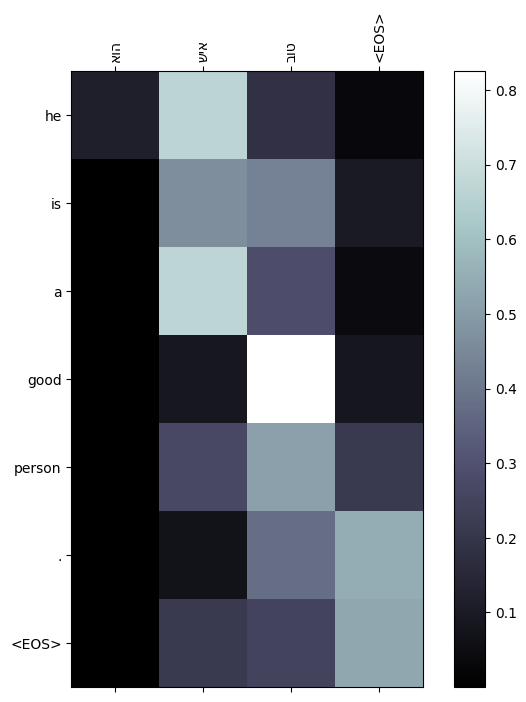

input = היא גבוהה יותר
output = she is taller than she looks . <EOS>


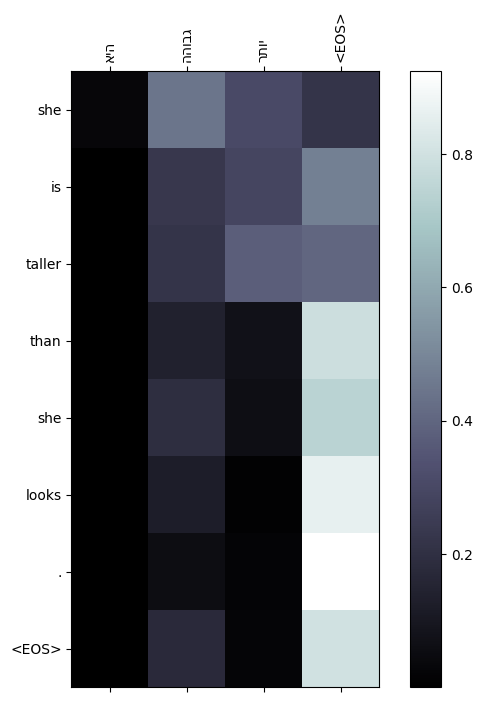

input = היא חכמה מאוד
output = she is very wise to bed young lady indeed .


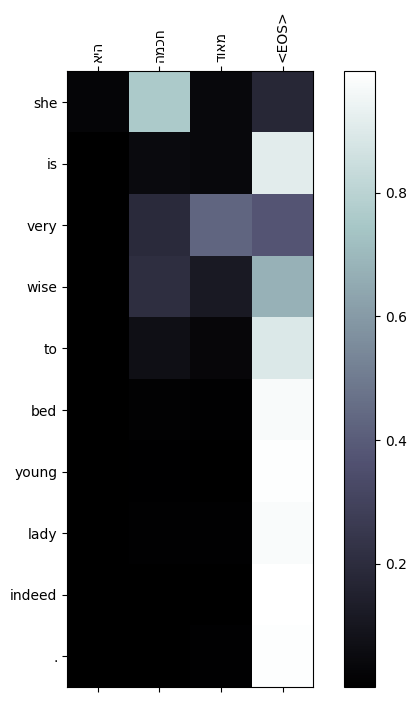

input = אני גאה בכם
output = i m proud of you . <EOS>


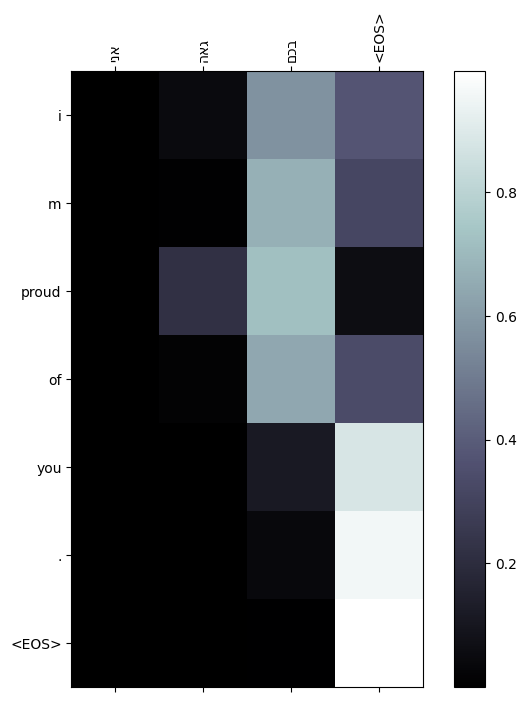

input = אני עייף
output = i am tired of my daughter . <EOS>


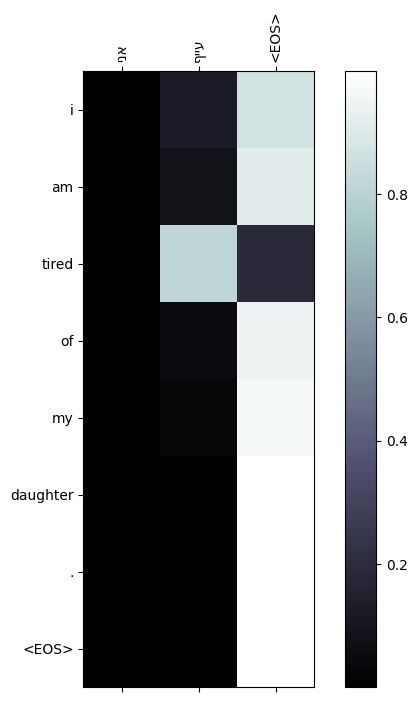

In [31]:


!pip install python-bidi arabic-reshaper

from bidi.algorithm import get_display
import arabic_reshaper

def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)

    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    input_tokens = input_sentence.split(' ') + ['<EOS>']
    input_tokens = [get_display(arabic_reshaper.reshape(w)) for w in input_tokens]

    ax.set_xticks(range(len(input_tokens)))
    ax.set_yticks(range(len(output_words)))

    ax.set_xticklabels(input_tokens, rotation=90)
    ax.set_yticklabels(output_words)

    ax.xaxis.set_major_locator(ticker.FixedLocator(range(len(input_tokens))))
    ax.yaxis.set_major_locator(ticker.FixedLocator(range(len(output_words))))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])



evaluateAndShowAttention('הוא איש טוב')

evaluateAndShowAttention('היא גבוהה יותר')

evaluateAndShowAttention('היא חכמה מאוד')

evaluateAndShowAttention('אני גאה בכם')

evaluateAndShowAttention('אני עייף')


### 3.

3) Do you think this model performs well? Why or why not? What are its limitations/disadvantages? What would you do to improve it?  

3. The translations itself are accurat in most cases, However from the observed heatmaps it looks like the model didnt really know what word retales to the word in the translation sentences. In addition the model as it stands limited for only sepecific perfixes and maximum length of sentences.
The biggest improvement would be moving from RNNs to Transformers. Transformers use Self-Attention, allowing the model to process all words in a sentence simultaneously rather than one-by-one, which drastically improves translation quality and training speed.

### 4.

4) Using any neural network architecture of your liking, build  a model with the aim to beat the model in 2.a. Compare your results in a meaningful way, and add a short explanation to why you think/thought your suggested network is better.

4. From the printed example, as a qualitive analysis only I saw that while both models successfully learned to translate Hebrew to English, the Transformer architecture outperformed the Seq2Seq model in terms of translation accuracy. The Seq2Seq model occasionally suffered from hallucinations and struggled with sequence termination. In contrast, the Transformer multi-head attention mechanism provided a more robust understanding of sentence structure.

In [35]:
SOS_token = 0
EOS_token = 1
PAD_token = 2
MAX_LENGTH = 10

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=50):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.d_k = d_model // num_heads
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)
        q = self.w_q(q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        k = self.w_k(k).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        v = self.w_v(v).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attn = torch.softmax(scores, dim=-1)
        context = torch.matmul(attn, v).transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        return self.w_o(context)


class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_layers, num_heads, d_ff, dropout=0.1):
        super(Transformer, self).__init__()
        self.encoder = TransformerEncoder(src_vocab_size, d_model, num_layers, num_heads, d_ff, dropout)
        self.decoder = TransformerDecoder(tgt_vocab_size, d_model, num_layers, num_heads, d_ff, dropout)
        self.generator = nn.Linear(d_model, tgt_vocab_size)

    def forward(self, src, tgt, src_mask, tgt_mask):
        enc_output = self.encoder(src, src_mask)
        dec_output = self.decoder(tgt, enc_output, src_mask, tgt_mask)
        return self.generator(dec_output)

def make_masks(src, tgt, pad_idx):
    src_mask = (src != pad_idx).unsqueeze(1).unsqueeze(2)
    tgt_pad_mask = (tgt != pad_idx).unsqueeze(1).unsqueeze(2)
    tgt_len = tgt.size(1)
    look_ahead_mask = torch.tril(torch.ones(tgt_len, tgt_len)).bool().to(src.device)
    tgt_mask = tgt_pad_mask & look_ahead_mask
    return src_mask, tgt_mask

In [36]:
input_ids = np.full((len(pairs), MAX_LENGTH), PAD_token)
target_ids = np.full((len(pairs), MAX_LENGTH), PAD_token)

for i, (inp, tgt) in enumerate(pairs):
    inp_idx = [input_lang.word2index[w] for w in inp.split(' ')] + [EOS_token]
    tgt_idx = [output_lang.word2index[w] for w in tgt.split(' ')] + [EOS_token]
    input_ids[i, :len(inp_idx)] = inp_idx[:MAX_LENGTH]
    target_ids[i, :len(tgt_idx)] = tgt_idx[:MAX_LENGTH]

dataset = TensorDataset(torch.LongTensor(input_ids), torch.LongTensor(target_ids))
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

model = Transformer(input_lang.n_words, output_lang.n_words, 128, 4, 8, 512).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_token)

model.train()
for epoch in range(50):
    total_loss = 0
    for src, tgt in train_loader:
        src, tgt = src.to(device), tgt.to(device)
        tgt_input = tgt[:, :-1]
        tgt_labels = tgt[:, 1:]

        src_mask, tgt_mask = make_masks(src, tgt_input, PAD_token)
        preds = model(src, tgt_input, src_mask, tgt_mask)

        loss = criterion(preds.reshape(-1, output_lang.n_words), tgt_labels.reshape(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 10, Loss: 1.8292
Epoch 20, Loss: 0.9594
Epoch 30, Loss: 0.4239
Epoch 40, Loss: 0.1571
Epoch 50, Loss: 0.0686


In [37]:
def translate(model, sentence):
    model.eval()
    sentence = normalizeString(sentence)
    tokens = [input_lang.word2index[w] for w in sentence.split(' ')] + [EOS_token]
    src = torch.LongTensor(tokens).unsqueeze(0).to(device)

    tgt_indices = [SOS_token]
    for _ in range(MAX_LENGTH):
        tgt_tensor = torch.LongTensor(tgt_indices).unsqueeze(0).to(device)
        src_mask, tgt_mask = make_masks(src, tgt_tensor, PAD_token)

        with torch.no_grad():
            output = model(src, tgt_tensor, src_mask, tgt_mask)

        next_word = output[0, -1].argmax().item()
        tgt_indices.append(next_word)
        if next_word == EOS_token: break

    return ' '.join([output_lang.index2word[i] for i in tgt_indices if i not in [SOS_token, EOS_token, PAD_token]])

def evaluateRandomlyTransformer(model, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])

        output_sentence = translate(model, pair[0])
        print('<', output_sentence)
        print('')

evaluateRandomlyTransformer(model, 20)

> אני לא אסבול את זה יותר .
= i m not going to take it anymore .
< not going to take it anymore .

> אינני צבע .
= i m not a painter .
< not a painter .

> אני משוכנע שתום אמר לך את זה .
= i m sure tom told you that .
< tom told you that the it .

> אני קרח .
= i m bald .
< .

> אני מוכנה לעזור לך .
= i am ready to help you .
< to help you help you .

> את נמצאת בין חברים .
= you re with friends .
< with friends .

> אתה גורם לי בחילה !
= you re disgusting !
< !

> נסלח לך .
= you re forgiven .
< to you .

> אני הולך לחנות .
= i am going to the shop .
< going to the shop .

> אני הולכת עכשיו הביתה .
= i m going home now .
< going home now .

> אנו לא שותפים .
= we re not partners .
< not partners .

> אני הולך לבית השימוש .
= i m going to the bathroom .
< to the bathroom of losing .

> אני שמח לראות אותך .
= i m pleased to see you .
< happy to see you .

> הם זקנים .
= they re old .
< .

> אני די כועסת על עצמי .
= i m kind of mad at myself .
< mad at kind of myself .

> אין לה הגיון בר

In [38]:


transformer_path = '/content/drive/MyDrive/computational_learning/ps3/transformer.pth'

torch.save(model.state_dict(), transformer_path)

print(f"The Transformer model was saved successfully to: {transformer_path}")

The Transformer model was saved successfully to: /content/drive/MyDrive/computational_learning/ps3/transformer.pth
